Import das bibliotecas necessárias para execução e criação dos modelos

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

In [ ]:
#for replicability purposes
tf.random.set_seed(91195003)
np.random.seed(91195003)

#for an easy reset backend session state
tf.keras.backend.clear_session()

Função que recebe o path do ficheiro csv que contem os dados e lê o mesmo 

In [ ]:
#load dataset
def load_dataset(path):
  return pd.read_csv(path)

Função que divide os conjunto total dos dados em dois conjuntos, os dados de treino e os dados de validação. Esta divisão é feita consoante o valor da percentagem recebido. Neste caso estão se a usar 90% dos dados para treino e 10% para validação.

In [ ]:
#split data into training and validation sets
def split_data(training, perc=10):
  train_idx = np.arange(0,int(len(training)*(100-perc)/100))
  val_idx = np.arange(int(len(training)* (100-perc)/100+1),len(training))
  return train_idx, val_idx


Esta função faz as preparações finais no dataframe que irá ser usado no modelo. Neste caso retira colunas inúteis e faz a conversão da feature "Date" para datetime e passando a mesma para o index do dataframe.  

In [ ]:
#preparing the data for the LSTM
def prepare_data(df):
        df_aux = df.copy()
        df_aux["Date"] = pd.to_datetime(df_aux["Date"])
        df_aux = df_aux.set_index('Date')
        df_aux = df_aux.drop(columns=["Unnamed: 0"])
        return df_aux


A função "data_normalization" como o nome indica, irá normalizar todas as features do dataset, tranformando-as todas entre valores de -1 e 1. Isto é um passo importante pois as features podem ter intervalos completamente diversificados o que pode afetar os modelos criados. Para isso usamos a normalização para transformar todas as variáveis na mesma ordem de grandeza.

In [ ]:
def data_normalization(df, norm_range=(-1, 1)):
    #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
    scaler = MinMaxScaler(feature_range=norm_range)
    colunas = [x for x in df.columns if x != 'obitos']
    print(colunas)
    for col in colunas:
      df[[col]] = scaler.fit_transform(df[[col]])
    df[['obitos']] = scaler.fit_transform(df[['obitos']])
    
    return scaler

Esta função irá gerar os plots com as curvas de "Validation loss" e "Training loss" 

In [ ]:
#plot learning curve
def plot_learning_curves(history, epochs):
  #accuracies and losses
  #dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse'])
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  epochs_range = range(epochs)
  #creating figure
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label='Training Loss')
  plt.plot(epochs_range,val_loss,label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training/Validation Loss')
  plt.show()


In [ ]:
#Plot time series data
def plot_confirmed_cases(data):
        plt.figure(figsize=(8,6))
        plt.plot(range(len(data)), data)
        plt.title('Dataset Features')
        plt.ylabel('Valores')
        plt.xlabel('Semanas')
        plt.show()

In [ ]:
#Preparing the dataset for the CNN
def to_supervised(df, timesteps):
  data = df.values
  X,y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of the timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      X.append(data[curr_pos:input_index,:])
      y.append(data[input_index:label_index,0])
        #using np.flot32 for GPU performance
  return np.array(X).astype('float32'), np.array(y).astype('float32')

Função que irá calcular o RMSE para os resultados obtidos

In [ ]:
#Building the model
def rmse(y_true, y_pred):
  return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


Função onde cria o modelo indicando a sua composição em termos de tipo e numero de camadas e outros parametros

In [ ]:
def build_model(timesteps, features, filters= 16, kernel_size=1, pool_size =2 ):
  #using the functional API
  inputs = tf.keras.layers.Input(shape=(timesteps, features))
  #microarchitecture
  x = tf.keras.layers.Conv1D(filters=filters, kernel_size = kernel_size, activation='relu', data_format = 'channels_last')(inputs)
  x = tf.keras.layers.AveragePooling1D(pool_size = pool_size, data_format = 'channels_first')(x)
  #last layers
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(filters)(x)
  outputs = tf.keras.layers.Dense(1)(x)
  #the model
  cnnModel = tf.keras.Model(inputs=inputs, outputs=outputs, name='cnn_model')
  tf.keras.utils.plot_model(cnnModel,'cnnmodel.png', show_shapes=True)
  return cnnModel

Função onde é compilado o modelo, divididos os dados em dados de treino e validação, efetuado o fit e avaliação dos modelos e criados os plot com as curvas de loss para cada iteração do time series cross validation.

In [ ]:
def compile_and_fit(model, epochs, batch_size,learning_rate):
  #compile
  model.compile(loss=rmse, optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics = ['mae',rmse])
  #fit
  hist_list = list()
  loss_list = list()
  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=cv_splits)
  for train_index, test_index in tscv.split(X):
    train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
    #build data
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_index], y[test_index]
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size,shuffle=False)
    metrics = model.evaluate(X_test, y_test)

    plot_learning_curves(history, epochs)
    hist_list.append(history)

  return model, hist_list

Função que irá prever os valores pretendidos efetunado também a sua desnormalização

In [ ]:
def forecast(model, df, timesteps, multisteps, scaler):
  input_seq = df[-timesteps:].values #getting the last sequence of known value
  inp = input_seq
  forecasts = list()
  print(inp)
  #multistep tells us how many iterations we want to perform
  #i. e. how many days we want to predict
  for step in range(1, multisteps+1):
    #implement
    inp = inp.reshape(1, timesteps, n_variate)
    pred = model.predict(inp)
    yhat_inversed = scaler.inverse_transform(pred)
    forecasts.append(yhat_inversed)
    #prepare new input to forecast the next day
    # inp = np.append(inp[0], pred)        
    # inp = inp[-timesteps:]
    # list_pred = [pred[0][i] for i in range(len(pred[0]))]
    # print('list_yhat:')
    # print(list_pred)
    # inp= np.append(inp[0],[list_pred],axis=0) #adiciona previsão recente ao input
    # inp = inp[-timesteps:]#vai ao input buscar os ultimos timesteps registados
    # print(step)
    print(step)
            
  return forecasts

Função que irá criar o gráfico com as curvas dos valores reais e dos valores previstos

In [ ]:
def plot_forecast(data, forecasts):
        plt.figure(figsize=(8,6))
        plt.plot(range(len(data)),data["obitos"], color='green', label='Confirmed')
        
        fi=[]
        for f in forecasts:
          fi.append(f[0][0])
          print('Previsão:' + str(f))
        print(fi)
        
        plt.plot(range(len(data)-1,len(data)+len(fi)-1), fi, color='red', label='Forecasts')
    
        plt.title('Óbitos em Portugal')
        plt.ylabel('Número de Óbitos')
        plt.xlabel('Semanas')
        plt.legend()
        plt.show()

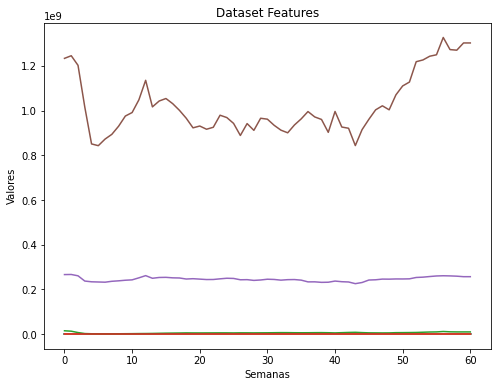

['confirmados_novos', 'recuperados', 'Temperature', 'Visibility', 'total_testes', 'testes_pcr', 'testes_antigenio', 'new_cases_per_million_Austria', 'new_deaths_per_million_Austria', 'new_cases_per_million_Belgium', 'new_deaths_per_million_Belgium', 'icu_patients_per_million_Belgium', 'hosp_patients_per_million_Belgium', 'new_deaths_per_million_Bulgaria', 'new_cases_per_million_Canada', 'new_deaths_per_million_Canada', 'icu_patients_per_million_Canada', 'new_cases_per_million_Cyprus', 'new_deaths_per_million_Czechia', 'hosp_patients_per_million_Czechia', 'new_cases_per_million_Denmark', 'new_tests_per_thousand_Estonia', 'icu_patients_per_million_France', 'new_cases_per_million_Georgia', 'new_cases_per_million_Germany', 'new_deaths_per_million_Germany', 'icu_patients_per_million_Germany', 'new_deaths_per_million_Hungary', 'hosp_patients_per_million_Hungary', 'positive_rate_India', 'new_cases_per_million_Ireland', 'new_deaths_per_million_Ireland', 'icu_patients_per_million_Ireland', 'hos

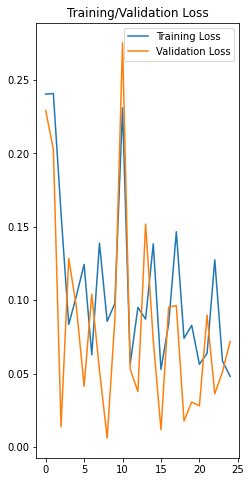

Epoch 1/25
27/27 [==============================] - 0s 3ms/step - loss: 0.0802 - mae: 0.0802 - rmse: 0.0802 - val_loss: 0.1788 - val_mae: 0.1788 - val_rmse: 0.1788
Epoch 2/25
27/27 [==============================] - 0s 2ms/step - loss: 0.0597 - mae: 0.0597 - rmse: 0.0597 - val_loss: 0.1614 - val_mae: 0.1614 - val_rmse: 0.1614
Epoch 3/25
27/27 [==============================] - 0s 2ms/step - loss: 0.0556 - mae: 0.0556 - rmse: 0.0556 - val_loss: 0.2169 - val_mae: 0.2169 - val_rmse: 0.2169
Epoch 4/25
27/27 [==============================] - 0s 2ms/step - loss: 0.1379 - mae: 0.1379 - rmse: 0.1379 - val_loss: 0.2016 - val_mae: 0.2016 - val_rmse: 0.2016
Epoch 5/25
27/27 [==============================] - 0s 2ms/step - loss: 0.0905 - mae: 0.0905 - rmse: 0.0905 - val_loss: 0.2384 - val_mae: 0.2384 - val_rmse: 0.2384
Epoch 6/25
27/27 [==============================] - 0s 2ms/step - loss: 0.0733 - mae: 0.0733 - rmse: 0.0733 - val_loss: 0.1894 - val_mae: 0.1894 - val_rmse: 0.1894
Epoch 7/25
27/27

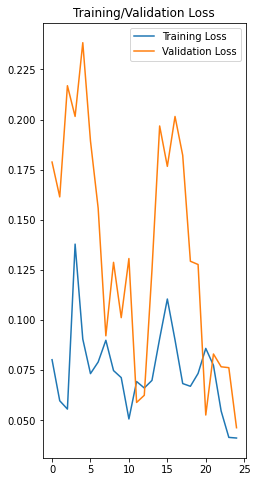

Epoch 1/25
40/40 [==============================] - 0s 3ms/step - loss: 0.0622 - mae: 0.0622 - rmse: 0.0622 - val_loss: 0.1458 - val_mae: 0.1458 - val_rmse: 0.1458
Epoch 2/25
40/40 [==============================] - 0s 2ms/step - loss: 0.1114 - mae: 0.1114 - rmse: 0.1114 - val_loss: 0.0558 - val_mae: 0.0558 - val_rmse: 0.0558
Epoch 3/25
40/40 [==============================] - 0s 2ms/step - loss: 0.1691 - mae: 0.1691 - rmse: 0.1691 - val_loss: 0.0992 - val_mae: 0.0992 - val_rmse: 0.0992
Epoch 4/25
40/40 [==============================] - 0s 2ms/step - loss: 0.0478 - mae: 0.0478 - rmse: 0.0478 - val_loss: 0.0706 - val_mae: 0.0706 - val_rmse: 0.0706
Epoch 5/25
40/40 [==============================] - 0s 2ms/step - loss: 0.0439 - mae: 0.0439 - rmse: 0.0439 - val_loss: 0.0729 - val_mae: 0.0729 - val_rmse: 0.0729
Epoch 6/25
40/40 [==============================] - 0s 2ms/step - loss: 0.0474 - mae: 0.0474 - rmse: 0.0474 - val_loss: 0.0694 - val_mae: 0.0694 - val_rmse: 0.0694
Epoch 7/25
40/40

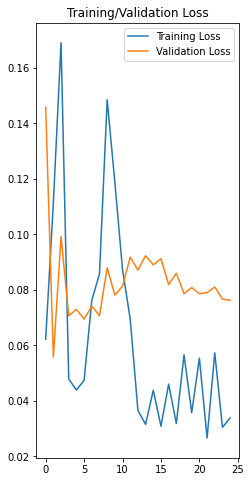

[[-0.98907104 -0.95624443 -0.93725785 -0.07045291  0.78599222  0.65485477
  -0.35377247  1.         -0.64328341 -0.70843591 -0.75782161 -0.76899076
  -0.26988684 -0.51217565 -0.13936524  0.12751284 -0.69270226  0.31199613
   0.48632739 -0.52153857 -0.482462   -0.7468608  -0.1484868  -0.00997165
  -0.67426232  0.20671277 -0.62537665  0.00576701 -0.07526023 -0.21727635
   1.         -0.92122484 -0.87027262 -0.74180806 -0.89442814 -0.2844982
  -0.75175562  0.00805119 -0.16866547 -0.50387597 -0.37010294 -0.58583897
  -0.36260246  0.19565643 -0.56056374  0.37339919 -0.12270084 -0.81816357
  -0.51891597 -0.32258065 -0.6416187  -0.70905731 -0.59302326  0.18307113
   0.07918196 -0.66276573 -0.22152091 -0.30495875  0.10533489 -0.79022454
  -0.97503952 -0.61394845 -0.84445073 -0.14423449 -0.10522254 -0.76453366
  -0.5380259   0.81776447 -0.65355488 -0.91753152 -0.94881155 -0.98183478
  -0.91748467 -0.94323881 -0.9844358  -0.6990951  -0.73423129 -0.70131291
  -0.92027513 -1.          0.85938829  

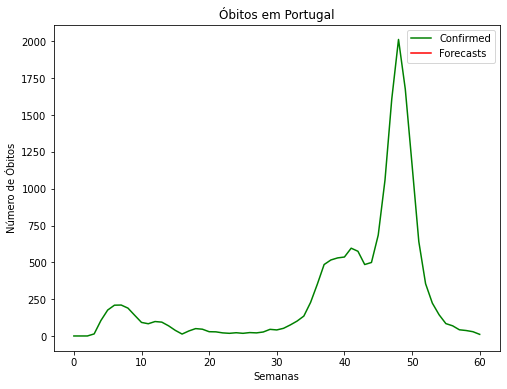

[array([[217.99098]], dtype=float32)]
Epoch 1/50
8/8 [==============================] - 1s 25ms/step - loss: 0.4616 - mae: 0.4394 - rmse: 0.4796 - val_loss: 1.1065 - val_mae: 1.1065 - val_rmse: 1.1065
Epoch 2/50
8/8 [==============================] - 0s 5ms/step - loss: 0.4069 - mae: 0.3872 - rmse: 0.4225 - val_loss: 1.0081 - val_mae: 1.0081 - val_rmse: 1.0081
Epoch 3/50
8/8 [==============================] - 0s 5ms/step - loss: 0.3633 - mae: 0.3476 - rmse: 0.3765 - val_loss: 0.9232 - val_mae: 0.9232 - val_rmse: 0.9232
Epoch 4/50
8/8 [==============================] - 0s 6ms/step - loss: 0.3322 - mae: 0.3180 - rmse: 0.3430 - val_loss: 0.8517 - val_mae: 0.8517 - val_rmse: 0.8517
Epoch 5/50
8/8 [==============================] - 0s 7ms/step - loss: 0.3065 - mae: 0.2906 - rmse: 0.3153 - val_loss: 0.7905 - val_mae: 0.7905 - val_rmse: 0.7905
Epoch 6/50
8/8 [==============================] - 0s 5ms/step - loss: 0.2854 - mae: 0.2656 - rmse: 0.2925 - val_loss: 0.7389 - val_mae: 0.7389 - val_rm

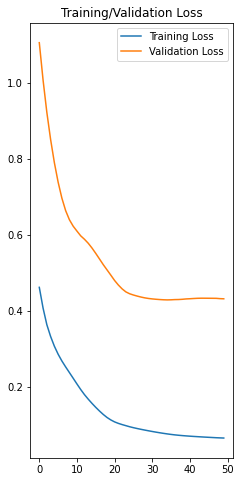

Epoch 1/50
14/14 [==============================] - 0s 6ms/step - loss: 0.2358 - mae: 0.2317 - rmse: 0.2482 - val_loss: 0.5812 - val_mae: 0.5802 - val_rmse: 0.5897
Epoch 2/50
14/14 [==============================] - 0s 4ms/step - loss: 0.2013 - mae: 0.1958 - rmse: 0.2110 - val_loss: 0.4791 - val_mae: 0.4777 - val_rmse: 0.4887
Epoch 3/50
14/14 [==============================] - 0s 3ms/step - loss: 0.1762 - mae: 0.1704 - rmse: 0.1833 - val_loss: 0.3994 - val_mae: 0.3974 - val_rmse: 0.4145
Epoch 4/50
14/14 [==============================] - 0s 4ms/step - loss: 0.1596 - mae: 0.1525 - rmse: 0.1646 - val_loss: 0.3518 - val_mae: 0.3498 - val_rmse: 0.3686
Epoch 5/50
14/14 [==============================] - 0s 3ms/step - loss: 0.1520 - mae: 0.1454 - rmse: 0.1561 - val_loss: 0.3254 - val_mae: 0.3232 - val_rmse: 0.3425
Epoch 6/50
14/14 [==============================] - 0s 4ms/step - loss: 0.1464 - mae: 0.1401 - rmse: 0.1502 - val_loss: 0.3134 - val_mae: 0.3111 - val_rmse: 0.3307
Epoch 7/50
14/14

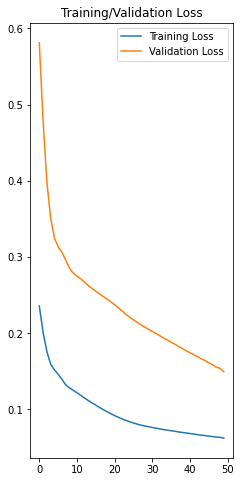

Epoch 1/50
20/20 [==============================] - 0s 10ms/step - loss: 0.1323 - mae: 0.1233 - rmse: 0.1323 - val_loss: 0.7265 - val_mae: 0.6957 - val_rmse: 0.7265
Epoch 2/50
20/20 [==============================] - 0s 4ms/step - loss: 0.1263 - mae: 0.1191 - rmse: 0.1263 - val_loss: 0.7026 - val_mae: 0.6703 - val_rmse: 0.7026
Epoch 3/50
20/20 [==============================] - 0s 3ms/step - loss: 0.1134 - mae: 0.1071 - rmse: 0.1134 - val_loss: 0.7143 - val_mae: 0.6843 - val_rmse: 0.7143
Epoch 4/50
20/20 [==============================] - 0s 4ms/step - loss: 0.1071 - mae: 0.1013 - rmse: 0.1071 - val_loss: 0.7259 - val_mae: 0.6978 - val_rmse: 0.7259
Epoch 5/50
20/20 [==============================] - 0s 3ms/step - loss: 0.1013 - mae: 0.0961 - rmse: 0.1013 - val_loss: 0.7342 - val_mae: 0.7076 - val_rmse: 0.7342
Epoch 6/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0964 - mae: 0.0914 - rmse: 0.0964 - val_loss: 0.7373 - val_mae: 0.7116 - val_rmse: 0.7373
Epoch 7/50
20/2

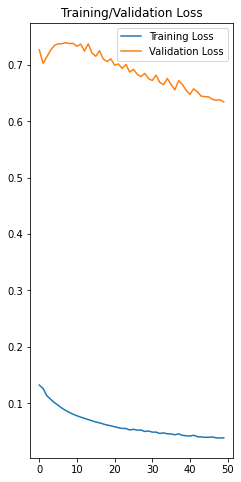

[[-0.98907104 -0.95624443 -0.93725785 -0.07045291  0.78599222  0.65485477
  -0.35377247  1.         -0.64328341 -0.70843591 -0.75782161 -0.76899076
  -0.26988684 -0.51217565 -0.13936524  0.12751284 -0.69270226  0.31199613
   0.48632739 -0.52153857 -0.482462   -0.7468608  -0.1484868  -0.00997165
  -0.67426232  0.20671277 -0.62537665  0.00576701 -0.07526023 -0.21727635
   1.         -0.92122484 -0.87027262 -0.74180806 -0.89442814 -0.2844982
  -0.75175562  0.00805119 -0.16866547 -0.50387597 -0.37010294 -0.58583897
  -0.36260246  0.19565643 -0.56056374  0.37339919 -0.12270084 -0.81816357
  -0.51891597 -0.32258065 -0.6416187  -0.70905731 -0.59302326  0.18307113
   0.07918196 -0.66276573 -0.22152091 -0.30495875  0.10533489 -0.79022454
  -0.97503952 -0.61394845 -0.84445073 -0.14423449 -0.10522254 -0.76453366
  -0.5380259   0.81776447 -0.65355488 -0.91753152 -0.94881155 -0.98183478
  -0.91748467 -0.94323881 -0.9844358  -0.6990951  -0.73423129 -0.70131291
  -0.92027513 -1.          0.85938829  

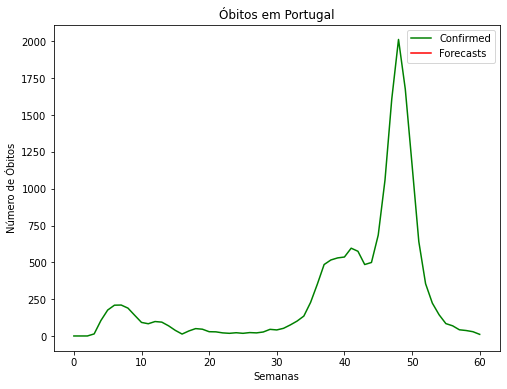

[array([[709.2564]], dtype=float32)]
Epoch 1/100
5/5 [==============================] - 1s 45ms/step - loss: 0.5431 - mae: 0.5410 - rmse: 0.5431 - val_loss: 0.5077 - val_mae: 0.5077 - val_rmse: 0.5077
Epoch 2/100
5/5 [==============================] - 0s 7ms/step - loss: 0.5404 - mae: 0.5383 - rmse: 0.5404 - val_loss: 0.5044 - val_mae: 0.5044 - val_rmse: 0.5044
Epoch 3/100
5/5 [==============================] - 0s 9ms/step - loss: 0.5377 - mae: 0.5356 - rmse: 0.5377 - val_loss: 0.5011 - val_mae: 0.5011 - val_rmse: 0.5011
Epoch 4/100
5/5 [==============================] - 0s 7ms/step - loss: 0.5351 - mae: 0.5329 - rmse: 0.5351 - val_loss: 0.4978 - val_mae: 0.4978 - val_rmse: 0.4978
Epoch 5/100
5/5 [==============================] - 0s 7ms/step - loss: 0.5324 - mae: 0.5302 - rmse: 0.5324 - val_loss: 0.4945 - val_mae: 0.4945 - val_rmse: 0.4945
Epoch 6/100
5/5 [==============================] - 0s 7ms/step - loss: 0.5297 - mae: 0.5275 - rmse: 0.5297 - val_loss: 0.4911 - val_mae: 0.4911 - v

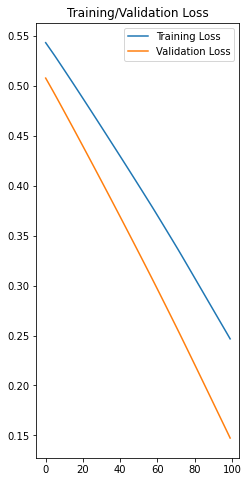

Epoch 1/100
9/9 [==============================] - 0s 21ms/step - loss: 0.2253 - mae: 0.2198 - rmse: 0.2253 - val_loss: 0.0442 - val_mae: 0.0303 - val_rmse: 0.0442
Epoch 2/100
9/9 [==============================] - 0s 6ms/step - loss: 0.2187 - mae: 0.2129 - rmse: 0.2187 - val_loss: 0.0408 - val_mae: 0.0298 - val_rmse: 0.0408
Epoch 3/100
9/9 [==============================] - 0s 5ms/step - loss: 0.2118 - mae: 0.2058 - rmse: 0.2118 - val_loss: 0.0384 - val_mae: 0.0322 - val_rmse: 0.0384
Epoch 4/100
9/9 [==============================] - 0s 4ms/step - loss: 0.2049 - mae: 0.1985 - rmse: 0.2049 - val_loss: 0.0374 - val_mae: 0.0346 - val_rmse: 0.0374
Epoch 5/100
9/9 [==============================] - 0s 5ms/step - loss: 0.1979 - mae: 0.1912 - rmse: 0.1979 - val_loss: 0.0380 - val_mae: 0.0371 - val_rmse: 0.0380
Epoch 6/100
9/9 [==============================] - 0s 6ms/step - loss: 0.1910 - mae: 0.1838 - rmse: 0.1910 - val_loss: 0.0401 - val_mae: 0.0395 - val_rmse: 0.0401
Epoch 7/100
9/9 [====

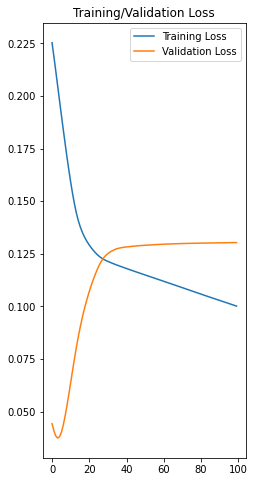

Epoch 1/100
14/14 [==============================] - 0s 6ms/step - loss: 0.1177 - mae: 0.1089 - rmse: 0.1257 - val_loss: 0.1677 - val_mae: 0.1660 - val_rmse: 0.1859
Epoch 2/100
14/14 [==============================] - 0s 4ms/step - loss: 0.1169 - mae: 0.1080 - rmse: 0.1245 - val_loss: 0.1665 - val_mae: 0.1650 - val_rmse: 0.1859
Epoch 3/100
14/14 [==============================] - 0s 4ms/step - loss: 0.1161 - mae: 0.1071 - rmse: 0.1233 - val_loss: 0.1656 - val_mae: 0.1641 - val_rmse: 0.1860
Epoch 4/100
14/14 [==============================] - 0s 4ms/step - loss: 0.1153 - mae: 0.1064 - rmse: 0.1223 - val_loss: 0.1649 - val_mae: 0.1633 - val_rmse: 0.1862
Epoch 5/100
14/14 [==============================] - 0s 4ms/step - loss: 0.1147 - mae: 0.1057 - rmse: 0.1214 - val_loss: 0.1643 - val_mae: 0.1626 - val_rmse: 0.1865
Epoch 6/100
14/14 [==============================] - 0s 5ms/step - loss: 0.1141 - mae: 0.1051 - rmse: 0.1206 - val_loss: 0.1639 - val_mae: 0.1621 - val_rmse: 0.1868
Epoch 7/10

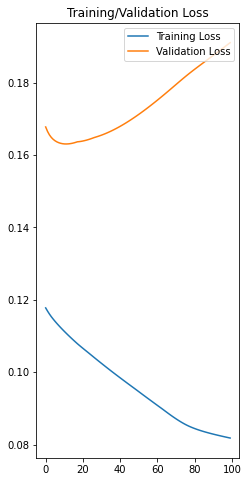

[[-0.98907104 -0.95624443 -0.93725785 -0.07045291  0.78599222  0.65485477
  -0.35377247  1.         -0.64328341 -0.70843591 -0.75782161 -0.76899076
  -0.26988684 -0.51217565 -0.13936524  0.12751284 -0.69270226  0.31199613
   0.48632739 -0.52153857 -0.482462   -0.7468608  -0.1484868  -0.00997165
  -0.67426232  0.20671277 -0.62537665  0.00576701 -0.07526023 -0.21727635
   1.         -0.92122484 -0.87027262 -0.74180806 -0.89442814 -0.2844982
  -0.75175562  0.00805119 -0.16866547 -0.50387597 -0.37010294 -0.58583897
  -0.36260246  0.19565643 -0.56056374  0.37339919 -0.12270084 -0.81816357
  -0.51891597 -0.32258065 -0.6416187  -0.70905731 -0.59302326  0.18307113
   0.07918196 -0.66276573 -0.22152091 -0.30495875  0.10533489 -0.79022454
  -0.97503952 -0.61394845 -0.84445073 -0.14423449 -0.10522254 -0.76453366
  -0.5380259   0.81776447 -0.65355488 -0.91753152 -0.94881155 -0.98183478
  -0.91748467 -0.94323881 -0.9844358  -0.6990951  -0.73423129 -0.70131291
  -0.92027513 -1.          0.85938829  

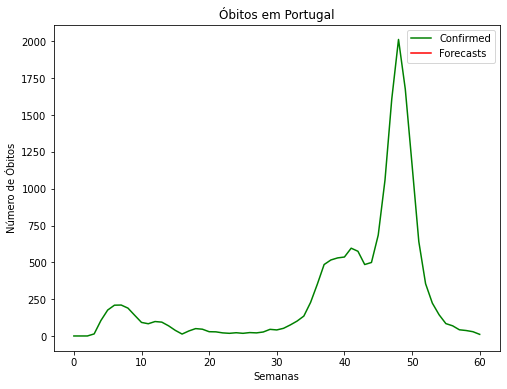

[array([[439.12976]], dtype=float32)]
Epoch 1/60
14/14 [==============================] - 1s 15ms/step - loss: 0.3902 - mae: 0.3902 - rmse: 0.3902 - val_loss: 0.0887 - val_mae: 0.0887 - val_rmse: 0.0887
Epoch 2/60
14/14 [==============================] - 0s 3ms/step - loss: 0.3872 - mae: 0.3872 - rmse: 0.3872 - val_loss: 0.0717 - val_mae: 0.0717 - val_rmse: 0.0717
Epoch 3/60
14/14 [==============================] - 0s 4ms/step - loss: 0.2586 - mae: 0.2586 - rmse: 0.2586 - val_loss: 0.3392 - val_mae: 0.3392 - val_rmse: 0.3392
Epoch 4/60
14/14 [==============================] - 0s 3ms/step - loss: 0.2129 - mae: 0.2129 - rmse: 0.2129 - val_loss: 0.0852 - val_mae: 0.0852 - val_rmse: 0.0852
Epoch 5/60
14/14 [==============================] - 0s 3ms/step - loss: 0.1210 - mae: 0.1210 - rmse: 0.1210 - val_loss: 0.0200 - val_mae: 0.0200 - val_rmse: 0.0200
Epoch 6/60
14/14 [==============================] - 0s 3ms/step - loss: 0.1325 - mae: 0.1325 - rmse: 0.1325 - val_loss: 0.1378 - val_mae: 0.1

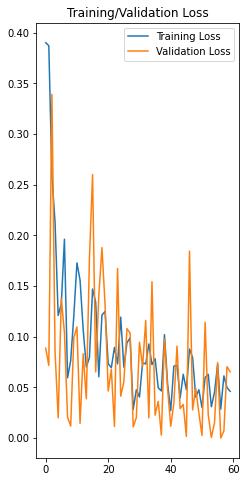

Epoch 1/60
27/27 [==============================] - 0s 4ms/step - loss: 0.0674 - mae: 0.0674 - rmse: 0.0674 - val_loss: 0.0136 - val_mae: 0.0136 - val_rmse: 0.0136
Epoch 2/60
27/27 [==============================] - 0s 2ms/step - loss: 0.0479 - mae: 0.0479 - rmse: 0.0479 - val_loss: 0.0025 - val_mae: 0.0025 - val_rmse: 0.0025
Epoch 3/60
27/27 [==============================] - 0s 2ms/step - loss: 0.0380 - mae: 0.0380 - rmse: 0.0380 - val_loss: 0.0129 - val_mae: 0.0129 - val_rmse: 0.0129
Epoch 4/60
27/27 [==============================] - 0s 2ms/step - loss: 0.0678 - mae: 0.0678 - rmse: 0.0678 - val_loss: 0.0173 - val_mae: 0.0173 - val_rmse: 0.0173
Epoch 5/60
27/27 [==============================] - 0s 3ms/step - loss: 0.0407 - mae: 0.0407 - rmse: 0.0407 - val_loss: 0.0178 - val_mae: 0.0178 - val_rmse: 0.0178
Epoch 6/60
27/27 [==============================] - 0s 2ms/step - loss: 0.0324 - mae: 0.0324 - rmse: 0.0324 - val_loss: 0.0281 - val_mae: 0.0281 - val_rmse: 0.0281
Epoch 7/60
27/27

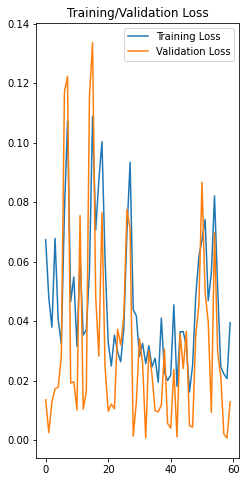

Epoch 1/60
39/39 [==============================] - 0s 3ms/step - loss: 0.0274 - mae: 0.0274 - rmse: 0.0274 - val_loss: 0.0612 - val_mae: 0.0612 - val_rmse: 0.0612
Epoch 2/60
39/39 [==============================] - 0s 2ms/step - loss: 0.0473 - mae: 0.0473 - rmse: 0.0473 - val_loss: 0.1319 - val_mae: 0.1319 - val_rmse: 0.1319
Epoch 3/60
39/39 [==============================] - 0s 2ms/step - loss: 0.0351 - mae: 0.0351 - rmse: 0.0351 - val_loss: 0.0864 - val_mae: 0.0864 - val_rmse: 0.0864
Epoch 4/60
39/39 [==============================] - 0s 3ms/step - loss: 0.0522 - mae: 0.0522 - rmse: 0.0522 - val_loss: 0.1656 - val_mae: 0.1656 - val_rmse: 0.1656
Epoch 5/60
39/39 [==============================] - 0s 2ms/step - loss: 0.0309 - mae: 0.0309 - rmse: 0.0309 - val_loss: 0.1122 - val_mae: 0.1122 - val_rmse: 0.1122
Epoch 6/60
39/39 [==============================] - 0s 2ms/step - loss: 0.0296 - mae: 0.0296 - rmse: 0.0296 - val_loss: 0.0846 - val_mae: 0.0846 - val_rmse: 0.0846
Epoch 7/60
39/39

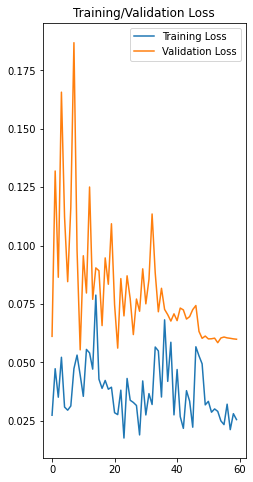

[[-0.97118728 -0.91880911 -0.89841389 -0.06542056  0.3618677   0.14154056
  -0.03218847 -0.4123767  -0.3540587  -0.51936649 -0.59130229 -0.66946753
   0.27950955 -0.15389717  0.58087227  1.         -0.51043367  1.
   1.         -0.1809098   0.05196264 -0.60810036  0.45643271  0.71506982
  -0.53766911  0.74654742 -0.49486659  0.66639589  1.          0.63474803
   0.53093525 -0.88793874 -0.78240344 -0.53445389 -0.80014589  0.14129866
  -0.75280899  0.78762997  0.33046833 -0.28568728  0.05388307 -0.20708052
   0.09003001  1.         -0.2411861   1.          0.43558499 -0.36361264
  -0.11842591 -0.25       -0.6416187  -0.41354034 -0.57953488  1.
   0.30676455 -0.39818198  0.32973384  0.27998639  0.20560748 -0.52646319
  -0.94468974 -0.21493503 -0.77778676  0.44927187  0.32338564 -0.74289127
  -0.16814312  0.86427146 -0.58606557 -0.89595156 -0.91213735 -0.95700586
  -0.82904768 -0.8841291  -0.98110061 -0.45146822 -0.57170885 -0.66356674
  -0.86556198 -0.96524487  0.90145488  0.29469682  0.2

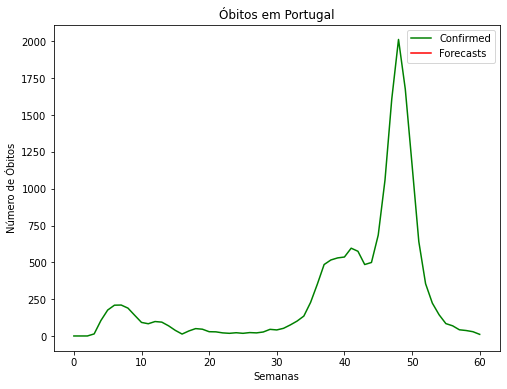

[array([[390.2908]], dtype=float32)]
Epoch 1/90
7/7 [==============================] - 1s 30ms/step - loss: 1.1373 - mae: 1.1314 - rmse: 1.1373 - val_loss: 1.3288 - val_mae: 1.3288 - val_rmse: 1.3288
Epoch 2/90
7/7 [==============================] - 0s 6ms/step - loss: 1.0289 - mae: 1.0226 - rmse: 1.0289 - val_loss: 1.2093 - val_mae: 1.2093 - val_rmse: 1.2093
Epoch 3/90
7/7 [==============================] - 0s 5ms/step - loss: 0.9217 - mae: 0.9149 - rmse: 0.9217 - val_loss: 1.0893 - val_mae: 1.0893 - val_rmse: 1.0893
Epoch 4/90
7/7 [==============================] - 0s 9ms/step - loss: 0.8160 - mae: 0.8087 - rmse: 0.8160 - val_loss: 0.9687 - val_mae: 0.9687 - val_rmse: 0.9687
Epoch 5/90
7/7 [==============================] - 0s 6ms/step - loss: 0.7107 - mae: 0.7025 - rmse: 0.7107 - val_loss: 0.8475 - val_mae: 0.8475 - val_rmse: 0.8475
Epoch 6/90
7/7 [==============================] - 0s 6ms/step - loss: 0.6068 - mae: 0.5965 - rmse: 0.6068 - val_loss: 0.7260 - val_mae: 0.7260 - val_rms

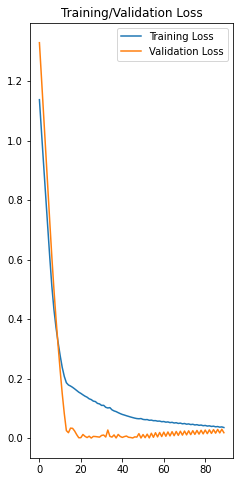

Epoch 1/90
14/14 [==============================] - 0s 15ms/step - loss: 0.0602 - mae: 0.0567 - rmse: 0.0616 - val_loss: 0.0976 - val_mae: 0.0762 - val_rmse: 0.0976
Epoch 2/90
14/14 [==============================] - 0s 4ms/step - loss: 0.0593 - mae: 0.0559 - rmse: 0.0603 - val_loss: 0.0901 - val_mae: 0.0763 - val_rmse: 0.0901
Epoch 3/90
14/14 [==============================] - 0s 4ms/step - loss: 0.0573 - mae: 0.0541 - rmse: 0.0581 - val_loss: 0.0870 - val_mae: 0.0765 - val_rmse: 0.0870
Epoch 4/90
14/14 [==============================] - 0s 5ms/step - loss: 0.0548 - mae: 0.0514 - rmse: 0.0562 - val_loss: 0.0930 - val_mae: 0.0770 - val_rmse: 0.0930
Epoch 5/90
14/14 [==============================] - 0s 4ms/step - loss: 0.0558 - mae: 0.0524 - rmse: 0.0567 - val_loss: 0.0862 - val_mae: 0.0770 - val_rmse: 0.0862
Epoch 6/90
14/14 [==============================] - 0s 4ms/step - loss: 0.0539 - mae: 0.0504 - rmse: 0.0547 - val_loss: 0.0847 - val_mae: 0.0773 - val_rmse: 0.0847
Epoch 7/90
14/1

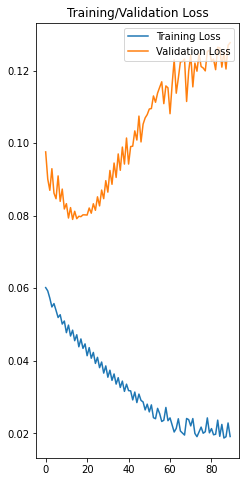

Epoch 1/90
20/20 [==============================] - 0s 5ms/step - loss: 0.0768 - mae: 0.0723 - rmse: 0.0881 - val_loss: 0.7749 - val_mae: 0.7731 - val_rmse: 0.7749
Epoch 2/90
20/20 [==============================] - 0s 4ms/step - loss: 0.0716 - mae: 0.0673 - rmse: 0.0818 - val_loss: 0.7367 - val_mae: 0.7352 - val_rmse: 0.7367
Epoch 3/90
20/20 [==============================] - 0s 4ms/step - loss: 0.0656 - mae: 0.0613 - rmse: 0.0750 - val_loss: 0.7124 - val_mae: 0.7109 - val_rmse: 0.7124
Epoch 4/90
20/20 [==============================] - 0s 4ms/step - loss: 0.0614 - mae: 0.0569 - rmse: 0.0700 - val_loss: 0.6933 - val_mae: 0.6917 - val_rmse: 0.6933
Epoch 5/90
20/20 [==============================] - 0s 4ms/step - loss: 0.0600 - mae: 0.0552 - rmse: 0.0678 - val_loss: 0.6761 - val_mae: 0.6744 - val_rmse: 0.6761
Epoch 6/90
20/20 [==============================] - 0s 5ms/step - loss: 0.0579 - mae: 0.0537 - rmse: 0.0650 - val_loss: 0.6652 - val_mae: 0.6634 - val_rmse: 0.6652
Epoch 7/90
20/20

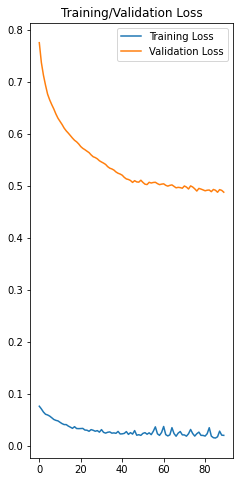

[[-0.97118728 -0.91880911 -0.89841389 -0.06542056  0.3618677   0.14154056
  -0.03218847 -0.4123767  -0.3540587  -0.51936649 -0.59130229 -0.66946753
   0.27950955 -0.15389717  0.58087227  1.         -0.51043367  1.
   1.         -0.1809098   0.05196264 -0.60810036  0.45643271  0.71506982
  -0.53766911  0.74654742 -0.49486659  0.66639589  1.          0.63474803
   0.53093525 -0.88793874 -0.78240344 -0.53445389 -0.80014589  0.14129866
  -0.75280899  0.78762997  0.33046833 -0.28568728  0.05388307 -0.20708052
   0.09003001  1.         -0.2411861   1.          0.43558499 -0.36361264
  -0.11842591 -0.25       -0.6416187  -0.41354034 -0.57953488  1.
   0.30676455 -0.39818198  0.32973384  0.27998639  0.20560748 -0.52646319
  -0.94468974 -0.21493503 -0.77778676  0.44927187  0.32338564 -0.74289127
  -0.16814312  0.86427146 -0.58606557 -0.89595156 -0.91213735 -0.95700586
  -0.82904768 -0.8841291  -0.98110061 -0.45146822 -0.57170885 -0.66356674
  -0.86556198 -0.96524487  0.90145488  0.29469682  0.2

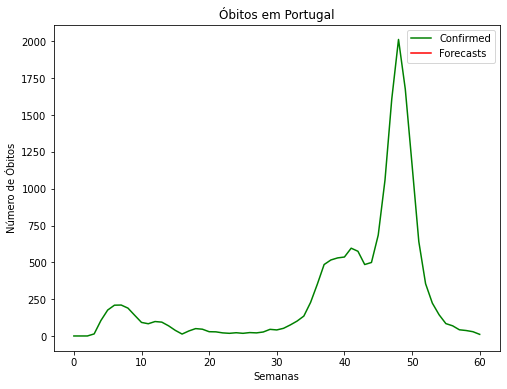

[array([[738.55896]], dtype=float32)]
Epoch 1/120
5/5 [==============================] - 1s 45ms/step - loss: 1.0209 - mae: 1.0123 - rmse: 0.9862 - val_loss: 0.6488 - val_mae: 0.6488 - val_rmse: 0.6488
Epoch 2/120
5/5 [==============================] - 0s 8ms/step - loss: 1.0140 - mae: 1.0053 - rmse: 0.9792 - val_loss: 0.6407 - val_mae: 0.6407 - val_rmse: 0.6407
Epoch 3/120
5/5 [==============================] - 0s 8ms/step - loss: 1.0072 - mae: 0.9984 - rmse: 0.9723 - val_loss: 0.6325 - val_mae: 0.6325 - val_rmse: 0.6325
Epoch 4/120
5/5 [==============================] - 0s 9ms/step - loss: 1.0004 - mae: 0.9915 - rmse: 0.9655 - val_loss: 0.6243 - val_mae: 0.6243 - val_rmse: 0.6243
Epoch 5/120
5/5 [==============================] - 0s 9ms/step - loss: 0.9936 - mae: 0.9847 - rmse: 0.9586 - val_loss: 0.6162 - val_mae: 0.6162 - val_rmse: 0.6162
Epoch 6/120
5/5 [==============================] - 0s 9ms/step - loss: 0.9868 - mae: 0.9778 - rmse: 0.9517 - val_loss: 0.6080 - val_mae: 0.6080 - 

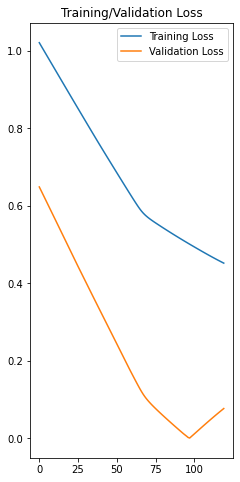

Epoch 1/120
9/9 [==============================] - 0s 10ms/step - loss: 0.2629 - mae: 0.2544 - rmse: 0.2629 - val_loss: 0.0698 - val_mae: 0.0698 - val_rmse: 0.0698
Epoch 2/120
9/9 [==============================] - 0s 6ms/step - loss: 0.2613 - mae: 0.2527 - rmse: 0.2613 - val_loss: 0.0672 - val_mae: 0.0672 - val_rmse: 0.0672
Epoch 3/120
9/9 [==============================] - 0s 5ms/step - loss: 0.2597 - mae: 0.2510 - rmse: 0.2597 - val_loss: 0.0631 - val_mae: 0.0631 - val_rmse: 0.0631
Epoch 4/120
9/9 [==============================] - 0s 6ms/step - loss: 0.2583 - mae: 0.2494 - rmse: 0.2583 - val_loss: 0.0586 - val_mae: 0.0586 - val_rmse: 0.0586
Epoch 5/120
9/9 [==============================] - 0s 6ms/step - loss: 0.2573 - mae: 0.2483 - rmse: 0.2573 - val_loss: 0.0549 - val_mae: 0.0549 - val_rmse: 0.0549
Epoch 6/120
9/9 [==============================] - 0s 6ms/step - loss: 0.2565 - mae: 0.2473 - rmse: 0.2565 - val_loss: 0.0518 - val_mae: 0.0518 - val_rmse: 0.0518
Epoch 7/120
9/9 [====

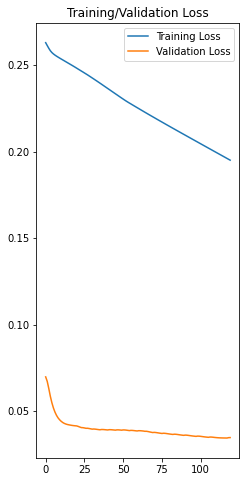

Epoch 1/120
13/13 [==============================] - 0s 7ms/step - loss: 0.2118 - mae: 0.2019 - rmse: 0.2118 - val_loss: 0.2412 - val_mae: 0.2369 - val_rmse: 0.1715
Epoch 2/120
13/13 [==============================] - 0s 4ms/step - loss: 0.2106 - mae: 0.2008 - rmse: 0.2106 - val_loss: 0.2415 - val_mae: 0.2372 - val_rmse: 0.1715
Epoch 3/120
13/13 [==============================] - 0s 4ms/step - loss: 0.2097 - mae: 0.2000 - rmse: 0.2097 - val_loss: 0.2418 - val_mae: 0.2375 - val_rmse: 0.1715
Epoch 4/120
13/13 [==============================] - 0s 4ms/step - loss: 0.2091 - mae: 0.1994 - rmse: 0.2091 - val_loss: 0.2421 - val_mae: 0.2378 - val_rmse: 0.1715
Epoch 5/120
13/13 [==============================] - 0s 4ms/step - loss: 0.2085 - mae: 0.1989 - rmse: 0.2085 - val_loss: 0.2425 - val_mae: 0.2382 - val_rmse: 0.1715
Epoch 6/120
13/13 [==============================] - 0s 5ms/step - loss: 0.2080 - mae: 0.1984 - rmse: 0.2080 - val_loss: 0.2427 - val_mae: 0.2385 - val_rmse: 0.1715
Epoch 7/12

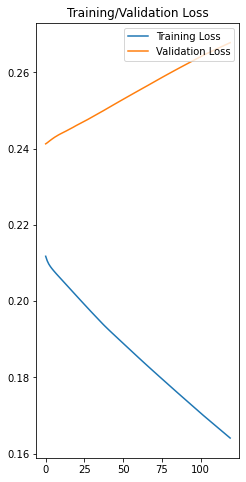

[[-0.97118728 -0.91880911 -0.89841389 -0.06542056  0.3618677   0.14154056
  -0.03218847 -0.4123767  -0.3540587  -0.51936649 -0.59130229 -0.66946753
   0.27950955 -0.15389717  0.58087227  1.         -0.51043367  1.
   1.         -0.1809098   0.05196264 -0.60810036  0.45643271  0.71506982
  -0.53766911  0.74654742 -0.49486659  0.66639589  1.          0.63474803
   0.53093525 -0.88793874 -0.78240344 -0.53445389 -0.80014589  0.14129866
  -0.75280899  0.78762997  0.33046833 -0.28568728  0.05388307 -0.20708052
   0.09003001  1.         -0.2411861   1.          0.43558499 -0.36361264
  -0.11842591 -0.25       -0.6416187  -0.41354034 -0.57953488  1.
   0.30676455 -0.39818198  0.32973384  0.27998639  0.20560748 -0.52646319
  -0.94468974 -0.21493503 -0.77778676  0.44927187  0.32338564 -0.74289127
  -0.16814312  0.86427146 -0.58606557 -0.89595156 -0.91213735 -0.95700586
  -0.82904768 -0.8841291  -0.98110061 -0.45146822 -0.57170885 -0.66356674
  -0.86556198 -0.96524487  0.90145488  0.29469682  0.2

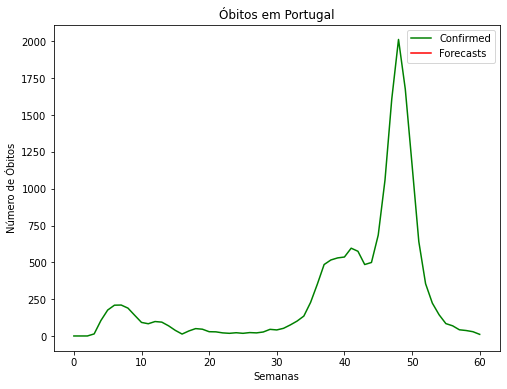

[array([[463.47754]], dtype=float32)]
Epoch 1/50
12/12 [==============================] - 1s 16ms/step - loss: 0.6996 - mae: 0.6996 - rmse: 0.6996 - val_loss: 0.2427 - val_mae: 0.2427 - val_rmse: 0.2427
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.2555 - mae: 0.2555 - rmse: 0.2555 - val_loss: 0.0396 - val_mae: 0.0396 - val_rmse: 0.0396
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0858 - mae: 0.0858 - rmse: 0.0858 - val_loss: 0.0940 - val_mae: 0.0940 - val_rmse: 0.0940
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1307 - mae: 0.1307 - rmse: 0.1307 - val_loss: 0.0609 - val_mae: 0.0609 - val_rmse: 0.0609
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0545 - mae: 0.0545 - rmse: 0.0545 - val_loss: 2.6160e-04 - val_mae: 2.6160e-04 - val_rmse: 2.6160e-04
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0579 - mae: 0.0579 - rmse: 0.0579 - val_loss: 0.0396 - 

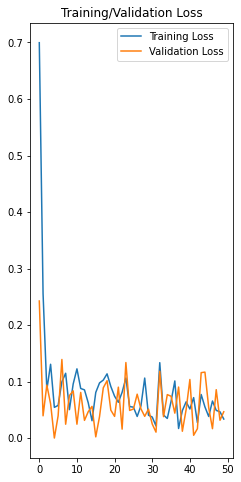

Epoch 1/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0438 - mae: 0.0438 - rmse: 0.0438 - val_loss: 0.1117 - val_mae: 0.1117 - val_rmse: 0.1117
Epoch 2/50
25/25 [==============================] - 0s 3ms/step - loss: 0.1689 - mae: 0.1689 - rmse: 0.1689 - val_loss: 0.0383 - val_mae: 0.0383 - val_rmse: 0.0383
Epoch 3/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0517 - mae: 0.0517 - rmse: 0.0517 - val_loss: 0.1193 - val_mae: 0.1193 - val_rmse: 0.1193
Epoch 4/50
25/25 [==============================] - 0s 2ms/step - loss: 0.0705 - mae: 0.0705 - rmse: 0.0705 - val_loss: 0.0383 - val_mae: 0.0383 - val_rmse: 0.0383
Epoch 5/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0762 - mae: 0.0762 - rmse: 0.0762 - val_loss: 0.0753 - val_mae: 0.0753 - val_rmse: 0.0753
Epoch 6/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0597 - mae: 0.0597 - rmse: 0.0597 - val_loss: 0.0153 - val_mae: 0.0153 - val_rmse: 0.0153
Epoch 7/50
25/25

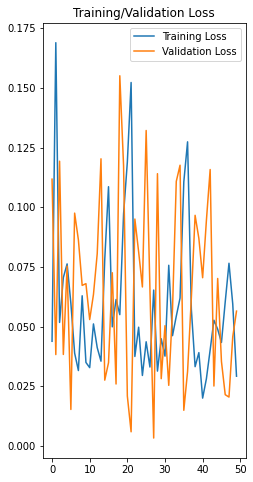

Epoch 1/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0516 - mae: 0.0516 - rmse: 0.0516 - val_loss: 0.0489 - val_mae: 0.0489 - val_rmse: 0.0489
Epoch 2/50
37/37 [==============================] - 0s 3ms/step - loss: 0.1036 - mae: 0.1036 - rmse: 0.1036 - val_loss: 0.1764 - val_mae: 0.1764 - val_rmse: 0.1764
Epoch 3/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0768 - mae: 0.0768 - rmse: 0.0768 - val_loss: 0.0729 - val_mae: 0.0729 - val_rmse: 0.0729
Epoch 4/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0321 - mae: 0.0321 - rmse: 0.0321 - val_loss: 0.0686 - val_mae: 0.0686 - val_rmse: 0.0686
Epoch 5/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0821 - mae: 0.0821 - rmse: 0.0821 - val_loss: 0.0475 - val_mae: 0.0475 - val_rmse: 0.0475
Epoch 6/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0471 - mae: 0.0471 - rmse: 0.0471 - val_loss: 0.0512 - val_mae: 0.0512 - val_rmse: 0.0512
Epoch 7/50
37/37

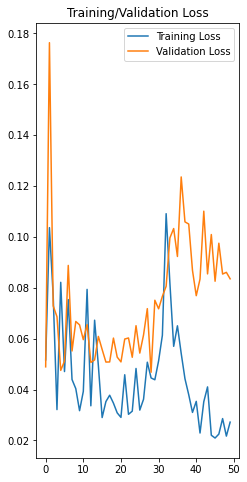

[[-9.58271237e-01 -9.32213592e-01 -8.76346311e-01 -6.47016535e-03
   1.67315175e-01 -2.56497135e-01 -2.47669739e-01 -8.02332886e-01
  -1.22757865e-01 -5.60376662e-01 -4.95974698e-01 -6.71259255e-01
   7.56226766e-02 -1.89799282e-01  7.88393299e-01  2.57588839e-01
  -6.83434367e-01  3.17007550e-01  2.96591879e-01  4.19501810e-01
   5.92306426e-01 -5.70594847e-01  3.37231165e-01  4.95200498e-01
  -7.65545844e-01  3.60212393e-01 -6.41683596e-01  3.32838433e-01
   9.72850332e-01  1.00000000e+00 -2.61664954e-01 -8.42274516e-01
  -7.78230014e-01 -4.02008805e-01 -7.12610028e-01  3.25435962e-01
  -7.03651685e-01  8.46814183e-01 -2.26774978e-01 -5.28077141e-01
  -1.33079012e-01 -3.72798500e-01  8.21909233e-02  7.07358187e-01
  -4.23513549e-01  3.70002011e-01  2.33129859e-01  1.00351229e-04
  -2.10341417e-02 -1.73387097e-01 -1.09826065e-01  1.14364175e-01
  -4.55813953e-01  6.93159070e-01  7.29417934e-01 -3.94019278e-01
   3.49581749e-01  3.39967679e-01  6.54205607e-01 -2.93164893e-01
  -4.15405

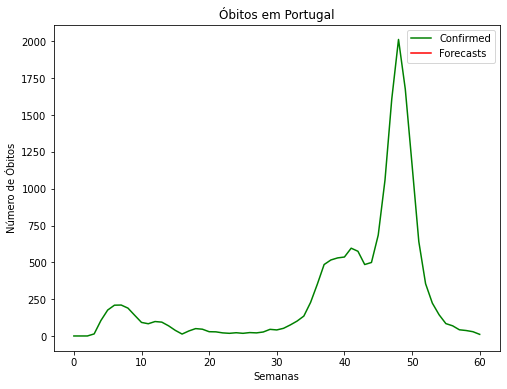

[array([[262.16254]], dtype=float32)]
Epoch 1/90
6/6 [==============================] - 1s 37ms/step - loss: 1.1003 - mae: 1.0952 - rmse: 1.1003 - val_loss: 0.8061 - val_mae: 0.8061 - val_rmse: 0.8061
Epoch 2/90
6/6 [==============================] - 0s 11ms/step - loss: 1.0282 - mae: 1.0232 - rmse: 1.0282 - val_loss: 0.7397 - val_mae: 0.7397 - val_rmse: 0.7397
Epoch 3/90
6/6 [==============================] - 0s 8ms/step - loss: 0.9594 - mae: 0.9543 - rmse: 0.9594 - val_loss: 0.6797 - val_mae: 0.6797 - val_rmse: 0.6797
Epoch 4/90
6/6 [==============================] - 0s 8ms/step - loss: 0.8912 - mae: 0.8860 - rmse: 0.8912 - val_loss: 0.6202 - val_mae: 0.6202 - val_rmse: 0.6202
Epoch 5/90
6/6 [==============================] - 0s 8ms/step - loss: 0.8236 - mae: 0.8182 - rmse: 0.8236 - val_loss: 0.5605 - val_mae: 0.5605 - val_rmse: 0.5605
Epoch 6/90
6/6 [==============================] - 0s 8ms/step - loss: 0.7562 - mae: 0.7505 - rmse: 0.7562 - val_loss: 0.5005 - val_mae: 0.5005 - val_r

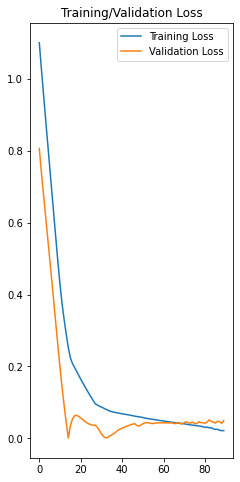

Epoch 1/90
13/13 [==============================] - 0s 15ms/step - loss: 0.0494 - mae: 0.0479 - rmse: 0.0480 - val_loss: 0.0917 - val_mae: 0.0894 - val_rmse: 0.0917
Epoch 2/90
13/13 [==============================] - 0s 5ms/step - loss: 0.0513 - mae: 0.0494 - rmse: 0.0496 - val_loss: 0.1070 - val_mae: 0.1050 - val_rmse: 0.1070
Epoch 3/90
13/13 [==============================] - 0s 5ms/step - loss: 0.0517 - mae: 0.0495 - rmse: 0.0503 - val_loss: 0.0952 - val_mae: 0.0927 - val_rmse: 0.0952
Epoch 4/90
13/13 [==============================] - 0s 5ms/step - loss: 0.0409 - mae: 0.0382 - rmse: 0.0393 - val_loss: 0.1101 - val_mae: 0.1076 - val_rmse: 0.1101
Epoch 5/90
13/13 [==============================] - 0s 4ms/step - loss: 0.0396 - mae: 0.0374 - rmse: 0.0382 - val_loss: 0.1145 - val_mae: 0.1118 - val_rmse: 0.1145
Epoch 6/90
13/13 [==============================] - 0s 5ms/step - loss: 0.0385 - mae: 0.0359 - rmse: 0.0371 - val_loss: 0.1139 - val_mae: 0.1110 - val_rmse: 0.1139
Epoch 7/90
13/1

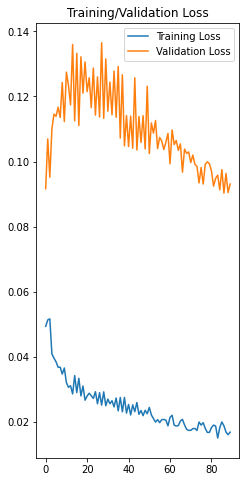

Epoch 1/90
19/19 [==============================] - 0s 5ms/step - loss: 0.0552 - mae: 0.0514 - rmse: 0.0579 - val_loss: 0.1325 - val_mae: 0.1060 - val_rmse: 0.1325
Epoch 2/90
19/19 [==============================] - 0s 4ms/step - loss: 0.0378 - mae: 0.0340 - rmse: 0.0385 - val_loss: 0.1766 - val_mae: 0.1477 - val_rmse: 0.1766
Epoch 3/90
19/19 [==============================] - 0s 5ms/step - loss: 0.0357 - mae: 0.0323 - rmse: 0.0351 - val_loss: 0.1483 - val_mae: 0.1276 - val_rmse: 0.1483
Epoch 4/90
19/19 [==============================] - 0s 6ms/step - loss: 0.0324 - mae: 0.0286 - rmse: 0.0328 - val_loss: 0.1353 - val_mae: 0.1105 - val_rmse: 0.1353
Epoch 5/90
19/19 [==============================] - 0s 5ms/step - loss: 0.0305 - mae: 0.0285 - rmse: 0.0311 - val_loss: 0.1579 - val_mae: 0.1337 - val_rmse: 0.1579
Epoch 6/90
19/19 [==============================] - 0s 5ms/step - loss: 0.0261 - mae: 0.0236 - rmse: 0.0263 - val_loss: 0.1353 - val_mae: 0.1113 - val_rmse: 0.1353
Epoch 7/90
19/19

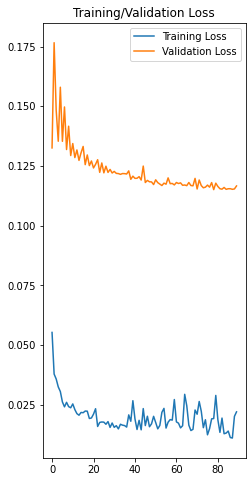

[[-9.58271237e-01 -9.32213592e-01 -8.76346311e-01 -6.47016535e-03
   1.67315175e-01 -2.56497135e-01 -2.47669739e-01 -8.02332886e-01
  -1.22757865e-01 -5.60376662e-01 -4.95974698e-01 -6.71259255e-01
   7.56226766e-02 -1.89799282e-01  7.88393299e-01  2.57588839e-01
  -6.83434367e-01  3.17007550e-01  2.96591879e-01  4.19501810e-01
   5.92306426e-01 -5.70594847e-01  3.37231165e-01  4.95200498e-01
  -7.65545844e-01  3.60212393e-01 -6.41683596e-01  3.32838433e-01
   9.72850332e-01  1.00000000e+00 -2.61664954e-01 -8.42274516e-01
  -7.78230014e-01 -4.02008805e-01 -7.12610028e-01  3.25435962e-01
  -7.03651685e-01  8.46814183e-01 -2.26774978e-01 -5.28077141e-01
  -1.33079012e-01 -3.72798500e-01  8.21909233e-02  7.07358187e-01
  -4.23513549e-01  3.70002011e-01  2.33129859e-01  1.00351229e-04
  -2.10341417e-02 -1.73387097e-01 -1.09826065e-01  1.14364175e-01
  -4.55813953e-01  6.93159070e-01  7.29417934e-01 -3.94019278e-01
   3.49581749e-01  3.39967679e-01  6.54205607e-01 -2.93164893e-01
  -4.15405

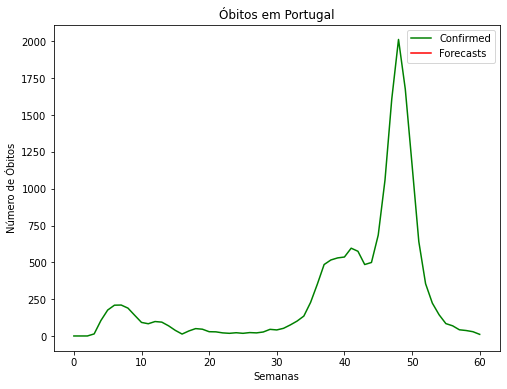

[array([[666.3028]], dtype=float32)]
Epoch 1/120
4/4 [==============================] - 1s 62ms/step - loss: 1.7859 - mae: 1.7772 - rmse: 1.7859 - val_loss: 2.0007 - val_mae: 2.0007 - val_rmse: 2.0007
Epoch 2/120
4/4 [==============================] - 0s 11ms/step - loss: 1.7799 - mae: 1.7712 - rmse: 1.7799 - val_loss: 1.9943 - val_mae: 1.9943 - val_rmse: 1.9943
Epoch 3/120
4/4 [==============================] - 0s 10ms/step - loss: 1.7740 - mae: 1.7652 - rmse: 1.7740 - val_loss: 1.9879 - val_mae: 1.9879 - val_rmse: 1.9879
Epoch 4/120
4/4 [==============================] - 0s 11ms/step - loss: 1.7681 - mae: 1.7593 - rmse: 1.7681 - val_loss: 1.9815 - val_mae: 1.9815 - val_rmse: 1.9815
Epoch 5/120
4/4 [==============================] - 0s 12ms/step - loss: 1.7622 - mae: 1.7534 - rmse: 1.7622 - val_loss: 1.9751 - val_mae: 1.9751 - val_rmse: 1.9751
Epoch 6/120
4/4 [==============================] - 0s 11ms/step - loss: 1.7563 - mae: 1.7475 - rmse: 1.7563 - val_loss: 1.9687 - val_mae: 1.968

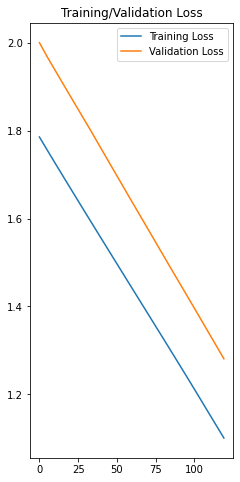

Epoch 1/120
9/9 [==============================] - 0s 12ms/step - loss: 1.2432 - mae: 1.2358 - rmse: 1.2566 - val_loss: 1.3437 - val_mae: 1.3437 - val_rmse: 1.3437
Epoch 2/120
9/9 [==============================] - 0s 8ms/step - loss: 1.2287 - mae: 1.2213 - rmse: 1.2421 - val_loss: 1.3286 - val_mae: 1.3286 - val_rmse: 1.3286
Epoch 3/120
9/9 [==============================] - 0s 7ms/step - loss: 1.2140 - mae: 1.2065 - rmse: 1.2273 - val_loss: 1.3131 - val_mae: 1.3131 - val_rmse: 1.3131
Epoch 4/120
9/9 [==============================] - 0s 6ms/step - loss: 1.1992 - mae: 1.1915 - rmse: 1.2124 - val_loss: 1.2976 - val_mae: 1.2976 - val_rmse: 1.2976
Epoch 5/120
9/9 [==============================] - 0s 7ms/step - loss: 1.1845 - mae: 1.1767 - rmse: 1.1975 - val_loss: 1.2821 - val_mae: 1.2821 - val_rmse: 1.2821
Epoch 6/120
9/9 [==============================] - 0s 7ms/step - loss: 1.1699 - mae: 1.1620 - rmse: 1.1828 - val_loss: 1.2669 - val_mae: 1.2669 - val_rmse: 1.2669
Epoch 7/120
9/9 [====

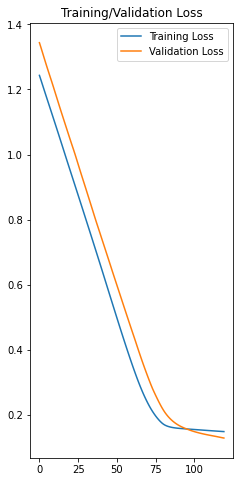

Epoch 1/120
13/13 [==============================] - 0s 7ms/step - loss: 0.1406 - mae: 0.1278 - rmse: 0.1340 - val_loss: 0.3500 - val_mae: 0.3353 - val_rmse: 0.2854
Epoch 2/120
13/13 [==============================] - 0s 6ms/step - loss: 0.1389 - mae: 0.1262 - rmse: 0.1319 - val_loss: 0.3467 - val_mae: 0.3315 - val_rmse: 0.2824
Epoch 3/120
13/13 [==============================] - 0s 4ms/step - loss: 0.1376 - mae: 0.1250 - rmse: 0.1308 - val_loss: 0.3441 - val_mae: 0.3285 - val_rmse: 0.2799
Epoch 4/120
13/13 [==============================] - 0s 5ms/step - loss: 0.1370 - mae: 0.1243 - rmse: 0.1302 - val_loss: 0.3446 - val_mae: 0.3290 - val_rmse: 0.2805
Epoch 5/120
13/13 [==============================] - 0s 8ms/step - loss: 0.1363 - mae: 0.1236 - rmse: 0.1295 - val_loss: 0.3457 - val_mae: 0.3302 - val_rmse: 0.2816
Epoch 6/120
13/13 [==============================] - 0s 5ms/step - loss: 0.1357 - mae: 0.1230 - rmse: 0.1288 - val_loss: 0.3469 - val_mae: 0.3315 - val_rmse: 0.2828
Epoch 7/12

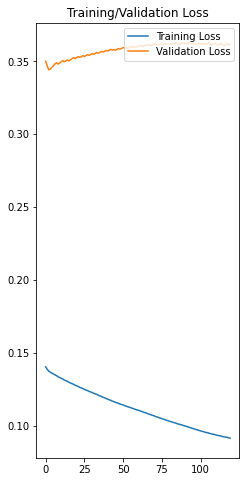

[[-9.58271237e-01 -9.32213592e-01 -8.76346311e-01 -6.47016535e-03
   1.67315175e-01 -2.56497135e-01 -2.47669739e-01 -8.02332886e-01
  -1.22757865e-01 -5.60376662e-01 -4.95974698e-01 -6.71259255e-01
   7.56226766e-02 -1.89799282e-01  7.88393299e-01  2.57588839e-01
  -6.83434367e-01  3.17007550e-01  2.96591879e-01  4.19501810e-01
   5.92306426e-01 -5.70594847e-01  3.37231165e-01  4.95200498e-01
  -7.65545844e-01  3.60212393e-01 -6.41683596e-01  3.32838433e-01
   9.72850332e-01  1.00000000e+00 -2.61664954e-01 -8.42274516e-01
  -7.78230014e-01 -4.02008805e-01 -7.12610028e-01  3.25435962e-01
  -7.03651685e-01  8.46814183e-01 -2.26774978e-01 -5.28077141e-01
  -1.33079012e-01 -3.72798500e-01  8.21909233e-02  7.07358187e-01
  -4.23513549e-01  3.70002011e-01  2.33129859e-01  1.00351229e-04
  -2.10341417e-02 -1.73387097e-01 -1.09826065e-01  1.14364175e-01
  -4.55813953e-01  6.93159070e-01  7.29417934e-01 -3.94019278e-01
   3.49581749e-01  3.39967679e-01  6.54205607e-01 -2.93164893e-01
  -4.15405

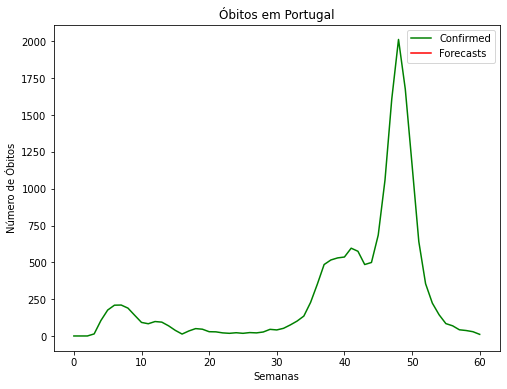

[array([[1305.1134]], dtype=float32)]


In [ ]:
################################
################################
########                ########
######## Main Execution ########
########                ########
################################
################################

n_variate = 4 #1, 2, 3  # number of features used by the model (using conf. cases to predict conf. cases) 

#the dataframes

df_raw = load_dataset('dataset_final_semanal.csv')
df_data = prepare_data(df_raw)
df = df_data.copy()
n_variate = len(df.columns)
plot_confirmed_cases(df_data) #the plot you saw previously
scaler = data_normalization(df) #scaling data to [-1,1]


##Optimization

tunning_dict = {               
                1: {'timesteps' : 1, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 25,  'batch_size' : 1 , "learning_rate":0.001},
                2: {'timesteps' : 1, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 50,  'batch_size' : 2 ,"learning_rate":0.0001},
                3: {'timesteps' : 1, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 100,  'batch_size' : 3 ,"learning_rate":0.00001},

                
                4: {'timesteps' : 2, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 60,  'batch_size' : 1 ,"learning_rate":0.001},
                5: {'timesteps' : 2, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 2 ,"learning_rate":0.0001},
                6: {'timesteps' : 2, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 3 ,"learning_rate":0.00001},
                
                7: {'timesteps' : 4, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 50,  'batch_size' : 1 ,"learning_rate":0.001},
                8: {'timesteps' : 4, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 2 ,"learning_rate":0.0001},
                9: {'timesteps' : 4, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 3 ,"learning_rate":0.00001}

                }
  # record da history de cada modelo
record = {}

#tunning the model cycle
for t in tunning_dict:
   # print(record[r])
   # fitting the model
   timesteps = tunning_dict[t]['timesteps']
   epochs = tunning_dict[t]['epochs']
   batch_size = tunning_dict[t]['batch_size']
   multisteps = tunning_dict[t]['multisteps']
   cv_splits = tunning_dict[t]['cv_splits']
   learning_rate = tunning_dict[t]['learning_rate']
   # print(timesteps,epochs,batch_size,cv_splits)

   X, y = to_supervised(df, timesteps)

   model = build_model(timesteps, n_variate)
   model, history = compile_and_fit(model, epochs, batch_size,learning_rate)
   path_to_save=r'modelo_auxclose'+str(t)+'.h5'
   model.save(path_to_save)
   # print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
   forecasts = forecast(model, df, timesteps, multisteps, scaler)
   plot_forecast(df_data, forecasts)
   print(forecasts)

   prev = []

   record[t] = history


  #Put the resulting metrics in a file
id_tunning = 1
id_split = 1

final_dict = {}

for r in record:
    # print(tunning_dict[1]['epochs'])
    loss = []
    mae = []
    rmse = []
    val_loss = []
    val_mae = []
    val_rmse = []

    for h in record[r]:
      # print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
      # plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
      # ['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
      # print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
      loss.append(sum(h.history['loss']) / len(h.history['loss']))
      mae.append(sum(h.history['mae']) / len(h.history['mae']))
      rmse.append(sum(h.history['rmse']) / len(h.history['rmse']))
      val_loss.append(sum(h.history['val_loss']) / len(h.history['val_loss']))
      val_mae.append(sum(h.history['val_mae']) / len(h.history['val_mae']))
      val_rmse.append(sum(h.history['val_rmse']) / len(h.history['val_rmse']))
      id_split += 1
    id_split = 1

    final_dict[id_tunning] = [sum(loss) / len(loss), sum(mae) / len(mae), sum(rmse) / len(rmse),
                              sum(val_loss) / len(val_loss), sum(val_mae) / len(val_mae), sum(val_rmse) / len(val_rmse)]

    id_tunning = id_tunning + 1




Criação de uma tabela com os resultados obtidos para cada optimização

In [ ]:
for f in final_dict:
    print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
    print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

final_df = pd.DataFrame.from_dict(final_dict, orient='index')
final_df.columns = ['Loss','MAE','RMSE','VAL_LOSS','VAL_MAE','VAL_RMSE']
final_df

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.08253367967903613, 0.08253367967903613, 0.08253367967903613, 0.10059443205595016, 0.10059443205595016, 0.10059443205595016] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  2  Valores:  [0.10012557946145535, 0.09361603202919165, 0.10311691018442314, 0.48757017453511553, 0.4783041297396024, 0.49369554380575814] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  3  Valores:  [0.20623014370600382, 0.19917393289506438, 0.2069328731050094, 0.2069665711869796, 0.1984114082592229, 0.21839596699923278] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  4  Valores:  [0.05937275534702672, 0.05937275534702672, 0.05937275534702672, 0.06178308493561215, 0.06178308493561215, 0.06178308493561215] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  5  Valores:  [0.07203032086016954, 0.0695895570744243, 0.07240907142835634, 0.25001411647708327, 0.24244223214961866, 0.2

,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.082534,0.082534,0.082534,0.100594,0.100594,0.100594
2,0.100126,0.093616,0.103117,0.487570,0.478304,0.493696
3,0.206230,0.199174,0.206933,0.206967,0.198411,0.218396
4,0.059373,0.059373,0.059373,0.061783,0.061783,0.061783
5,0.072030,0.069590,0.072409,0.250014,0.242442,0.250014
6,0.361532,0.351049,0.350621,0.176111,0.174639,0.149404
7,0.063488,0.063488,0.063488,0.067193,0.067193,0.067193
8,0.069832,0.066717,0.069794,0.109693,0.100420,0.109693
9,0.683829,0.671487,0.685041,0.851989,0.846858,0.830957


In [ ]:
#Results metrics to a file
final_df.to_csv(r"resultados_cnn_covid.csv",index=True)